# Noise extension

This script simulates the noise extension model described in SM 5.3. 

In each time step, all individuals have a certain probability (denoted as noise level) to adopt a random opinion between $X$ and $Y$. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.optimize import root
import matplotlib.lines as mlines
import copy
import pandas as pd

# import functions in my_functions
import ipynb.fs.defs.my_functions as myfun


In [2]:
def add_noise(opinion, noise_level):
    """
    Input opinion, which is an array
    each element has probability noise_level to be replaced with 0 or 1 with equal probability. 
    Output new opinion with added noise
    """
    
    dice = np.random.uniform(size = len(opinion)) # generate random number array between 0 and 1.  
    mask = dice < noise_level # select elements to replace with 0 or 1 randomly. 
    random_array = np.random.choice([0, 1], size = len(opinion))

    opinion[mask] = random_array[mask]
    
    return opinion 


def update(opinion, s, m, alpha, noise_level):
    """
    Function that updates opinion of each person using update function 
    """    
    N = len(opinion)
    x = np.sum(opinion)/N                           # portion of people with opinion 1

    p_01 = (1.-s)*m + s*myfun.f(x, alpha)           # transition rates from Y (0) to X (1)
    p_10 = (1.-s)*(1.-m) + s*myfun.f(1.-x, alpha)   # transition rate from X (1) to Y (0). 
        
    # update opinion 
    idx0 = (opinion == 0)
    idx1 = (opinion == 1)
    
    Dice = np.random.uniform(size = N)              # generate random numbers
    opinion[idx0 & (Dice < p_01)] = 1               # set those with value 0 to 1 with probability m. 
    opinion[idx1 & (Dice < p_10)] = 0               # set those with value 0 to 1 with probability m. 
    
    
    opinion = add_noise(opinion, noise_level)       # add noise
    
    return opinion

def initialize(N, x0, s):
    """
    Generate array of opinions and array of learning type
    """
    opinion = (np.random.uniform(size = N )< x0)*1             # generate array of opinion based on intial proportion of people with X, x0. 
                                                            # 1 = opiton X, 0 = option Y
    Ns = int(np.round(s*N))
    Ni = N - Ns 
    learn_type = [1]*Ni + [0]*Ns                           # generate array of learning type. 1 = individual learner, 0 = social learner. 
    np.random.shuffle(learn_type)                     
    learn_type = np.array(learn_type)
    return opinion, learn_type


def run_till_converge(N, x0, s, m, alpha, tmax, noise_level, save_history = 0, tol = 0.05):
    """
    Run simulation until convergence
    """
    xList = []
    opinion, learn_type = initialize(N, x0, s)           # generate array of opinion and learning type
    
    for t in range(tmax): 
        x = np.sum(opinion)/N                               # portion of people with opinion 1
        xList.append(x)
        opinion = update(opinion, s , m, alpha, noise_level)
        
        converge, avg, astd = myfun.checkConverge(xList, tol)    # check if simulation converged
        if converge ==1: 
            x_ss = avg
            break

    if save_history ==0: 
        # return dictionary of simulation parameters and results. tConv is time it took to convergence. 
        out = {"x_ss": avg, "s": s, "x0": x0, "m": m, "alpha": alpha, "tConv":t}
        
    else: 
        out = {"x_ss": avg, "s": s, "x0": x0, "m": m, "alpha": alpha, "tConv":t, "xList": xList}
    if converge == 0:
        print("warning: simulation didn't converge")
    return out 


# --- Simulation parameters --- 
N = 5
x0 = 0.4                                           # unitial portion of people with opinion x
m = 0.2
alpha = 1.5
tmax = 1000
s = 1

out = run_till_converge(N, x0, s, m, alpha, tmax, noise_level = 0.0, tol = 0.05)

In [3]:
out

{'x_ss': 1.0, 's': 1, 'x0': 0.4, 'm': 0.2, 'alpha': 1.5, 'tConv': 40}

## Loop through parameters

In [4]:
def run_multi_s(N, sList, m, x0List, noise_level, tol = 0.05):
    """
    run multiple simulations with parameters s and x0, with the same s distribution
    """
    
    res = []
    for x0 in x0List:
        for s in sList:
            opinion = (np.random.uniform(size = N) < x0)*1 # initialize opinion with x0. 
            out = run_till_converge(N, x0, s, m, alpha, tmax, noise_level, tol = tol)
            res.append(out)
    return pd.DataFrame(res)

# --- Parameters --- -
N = 10000
m = 0.6


sList = np.linspace(0, 1, 30)
x0List = np.array([0.1, 0.5, 0.9])

# run with no noise
res1 = run_multi_s(N, sList,m, x0List, noise_level = 0, tol = 0.01)



In [6]:
# 5% noise
res2 = run_multi_s(N, sList,m, x0List, noise_level = 0.05, tol = 0.01)

# 20% noise
res3 = run_multi_s(N, sList,m, x0List, noise_level = 0.2, tol = 0.01)

# 50% noise
res4 = run_multi_s(N, sList,m, x0List, noise_level = 0.5, tol = 0.01)

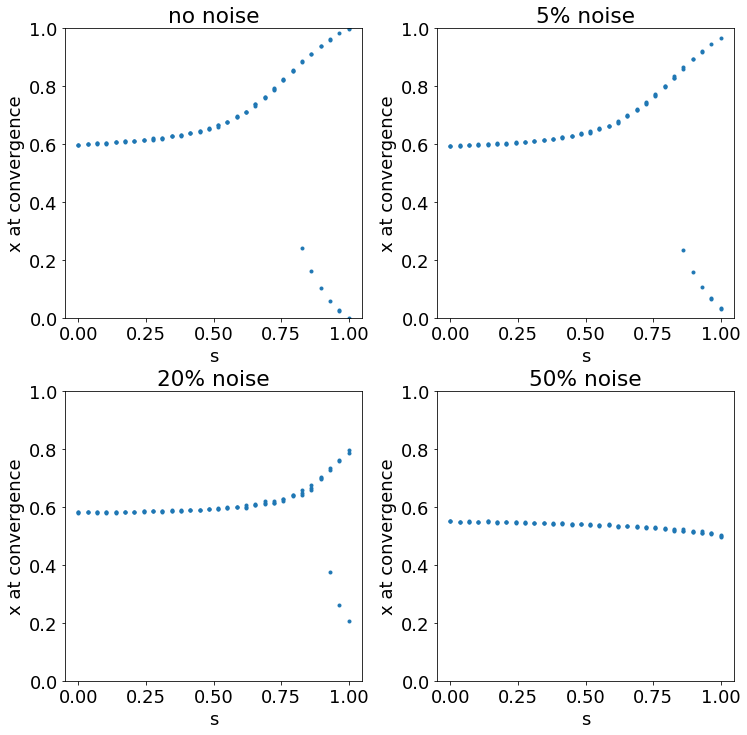

In [7]:
# Plot results
def plot_s_bif(ax, res):
    # plot bifurcation diagram with respect to m
    ax.plot(res.s, res.x_ss, ".")
    ax.set_xlabel("s")
    ax.set_ylabel("x at convergence")
    ax.set_ylim([0, 1])

row = 2
col = 2
fig, ax= plt.subplots(row,  col, figsize = (12, 12))
plot_s_bif(ax[0, 0], res1)
ax[0, 0].set_title("no noise")

plot_s_bif(ax[0, 1], res2)
ax[0, 1].set_title("5% noise")


plot_s_bif(ax[1, 0], res3)
ax[1, 0].set_title("20% noise")

plot_s_bif(ax[1, 1], res4)
ax[1, 1].set_title("50% noise")

plt.subplots_adjust(hspace = 0.25, wspace = 0.25)

### Plot example time trajectories

In [26]:
tmax = 1000
s = 0.9
m = 0.6
x0 = 0.5
alpha = 1.5
N = 2000

out1 = run_till_converge(N, x0, s, m, alpha, tmax, noise_level = 0, save_history = 1, tol = 0.01)
out2 = run_till_converge(N, x0, s, m, alpha, tmax, noise_level = 0.2, save_history = 1, tol = 0.01)



(0, 1)

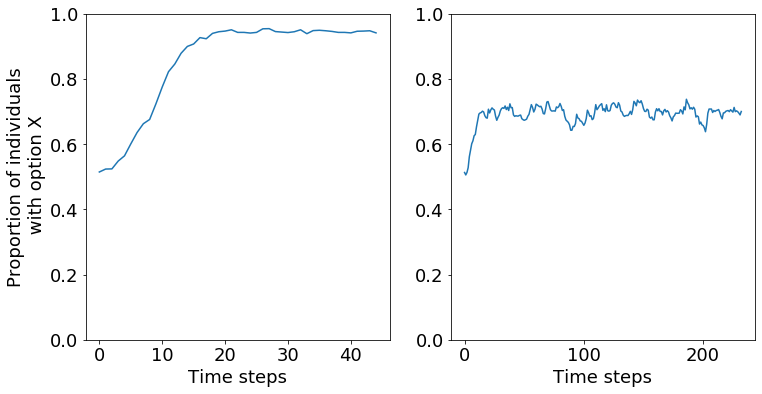

In [27]:
row = 1
col = 2
fig, ax= plt.subplots(row,  col, figsize = (12, 6))
plt.subplot(1, 2,1)
plt.plot(np.arange(out1["tConv"]+1), out1["xList"])
plt.xlabel("Time steps")
plt.ylabel("Proportion of individuals\n with option X")
plt.ylim([0, 1])



plt.subplot(1, 2,2)
plt.plot(np.arange(out2["tConv"]+1), out2["xList"])
plt.xlabel("Time steps")
plt.ylim([0, 1])


